In [16]:
from deap import tools, base, creator
import jax
import numpy as np
from diversity_algorithms.controllers.fixed_structure_nn_flax import SimpleNeuralControllerFlax
import jax.numpy as jnp
from diversity_algorithms.environments.brax_env import EvaluationFunctor
from diversity_algorithms.algorithms.novelty_search import set_creator
creator.create("FitnessMax", base.Fitness, weights=(1.0,)*1)
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)
set_creator(creator)


from diversity_algorithms.algorithms.utils import *
from diversity_algorithms.analysis.population_analysis import *
from diversity_algorithms.analysis.data_utils import *

import jax
from diversity_algorithms.algorithms.quality_diversity import *
from diversity_algorithms.environments.brax_env import create
from diversity_algorithms.environments.environments import registered_environments
from diversity_algorithms.analysis.coverage import *

from IPython.display import HTML
from brax.v1.io import html
import time

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/kuro/miniconda3/envs/PAND/lib/python3.11/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/kuro/miniconda3/envs/PAND/lib/python3.11/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [31]:
pop_size = 2024
nb_gen = 50
env_name = "ant-uni" # "ant-uni" or "ant-omni"
episode_length = 300
seed = 0
nn_num_hidden_layers = 2
nn_num_per_hidden = 64

In [32]:
params = {
        "env_name": env_name,  # "ant-uni" or "ant-omni"
        "verbosity": None,
        "pop_size": pop_size,
        "n_add": -1,
        "initial_seed_size": pop_size,
        "variant": "QD",
        "archive_type": "grid",
        "grid_n_bin": -1,
        "unstructured_neighborhood_radius": -1.0,
        "replace_strategy": "fitness",
        "sample_strategy": "random",
        "kdtree_update": "default",
        "nb_gen": nb_gen,
        "dump_period_evolvability": 0,
        "extra_evolvability_gens": [],
        "dump_period_offspring": 1,
        "dump_period_population": 1,
        "dump_period_archive_full": 100,
        "dump_period_archive_small": 1,
        "cxpb": 0,
        "mutpb": 1,
        "indpb": 0.1,
        "eta_m": 15.0,
        "min": -1.0,
        "max": 1.0,
        "k_nov": 15,
        "geno_type": "realarray",
        "eval_budget": -1,
        "seed": seed,
        "episode_length": episode_length,
        "evolvability_nb_samples": 5000,
}

# Initialise the controller and the Evalution function

In [33]:
env_params = registered_environments[params["env_name"]]

In [34]:
random_key = jax.random.PRNGKey(0)
controller = SimpleNeuralControllerFlax(87, 8, nn_num_hidden_layers, nn_num_per_hidden)
eval_functor = EvaluationFunctor(params["env_name"], 
                                 controller=controller, 
                                 episode_length=params["episode_length"],
                                 bd_function=env_params["bd_func"],
                                 output=env_params["eval_params"]["output"])

Environment set to ant-uni


# Toolbox Initilisation

In [35]:
toolbox = base.Toolbox()
toolbox.register("population", init_pop_controller, controller=controller)
toolbox.register("mutate", mutate, eta=params["eta_m"], min_val=params["min"], max_val=params["max"], indpb=params["indpb"])
toolbox.register("mate", cxBLend, alpha=0.5)
toolbox.register("map_eval", eval_functor)

v=str(params["variant"])
variant=v.replace(",","")
if (variant == "NS"): 
    toolbox.register("select", tools.selBest, fit_attr='novelty')
elif (variant == "Fit"):
    toolbox.register("select", tools.selBest, fit_attr='fitness')
else:
    toolbox.register("select", tools.selNSGA2)

# Initialisation run

In [36]:
population, random_key = toolbox.population(random_key, params["pop_size"])
fit, bd, random_key = toolbox.map_eval(jnp.asarray(population), random_key)

for ind, f, b in zip(population, fit, bd):
	ind.fitness.values = f
	ind.fit = f
	ind.parent_bd=None
	ind.bd=b
	ind.id = generate_uuid()
	ind.parent_id = None
	ind.dist_parent = -1
	ind.gen_created = 0

for ind in population:
	ind.am_parent=0
 
if((params["archive_type"] == "unstructured") or (params["archive_type"] == "archive")):
	# If no ball size is given, take a diameter of average size of a dimension / nb_bin
	if(params["unstructured_neighborhood_radius"] < 0):
		#Fetch behavior space dimensions
		gridinfo = registered_environments[params["env_name"]]["grid_features"]
		avg_dim_sizes = np.mean(np.array(gridinfo["max_x"]) - np.array(gridinfo["min_x"]))
		params["unstructured_neighborhood_radius"] = avg_dim_sizes / (2*gridinfo["nb_bin"])
		print("Unstructured archive replace radius autoset to %f" % params["unstructured_neighborhood_radius"])
	archive = UnstructuredArchive(population, r_ball_replace=params["unstructured_neighborhood_radius"], replace_strategy=replace_strategies[params["replace_strategy"]], k_nov_knn=params["k_nov"], kd_update_scheme=params["kdtree_update"])
elif(params["archive_type"] == "grid"):
	#Fetch behavior space dimensions
	gridinfo = registered_environments[params["env_name"]]["grid_features"]
	dim_ranges = list(zip(gridinfo["min_x"],gridinfo["max_x"]))
	if(params["grid_n_bin"] <= 0):
		params["grid_n_bin"] = gridinfo["nb_bin"] # If no specific discretization is given, take the environment default
		print("Archive grid bin number autoset to %d" % params["grid_n_bin"])
	archive = StructuredGrid(population, bins_per_dim=params["grid_n_bin"], dims_ranges=dim_ranges, replace_strategy=replace_strategies[params["replace_strategy"]], compute_novelty=True, k_nov_knn=params["k_nov"], kd_update_scheme=params["kdtree_update"])
else:
	raise RuntimeError("Unknown archive type %s" % params["archive_type"])

gen = 0

Archive grid bin number autoset to 10


# Learning loop

In [37]:
for gen in range(1, params["nb_gen"]):
    print("Generation %d" % gen)
    start = time.time()
    parents = archive.sample_archive(params["pop_size"], strategy=params["sample_strategy"])
    print("Sampling took %f" % (time.time() - start))

    # Mutate the geneotypes
    start = time.time()
    random_key, subkey = jax.random.split(random_key)
    keys = jax.random.split(subkey, len(parents))
    mutate_gen = jax.vmap(toolbox.mutate)(keys, jnp.asarray(parents))
    
    # Create the offsprings
    offspring = [creator.Individual([x]) for x in np.asarray(mutate_gen)]
    for i in range(len(offspring)):
        offspring[i] =  offspring[i][0]
        offspring[i].fitness = creator.FitnessMax()
        offspring[i].bd = parents[i].bd
        offspring[i].id = parents[i].id
    print("Mutating took %f" % (time.time() - start))
    
    start = time.time()
    fit, bd, random_key = toolbox.map_eval(jnp.array(offspring), random_key)
    print("Evaluating took %f" % (time.time() - start))
    
    for ind, f, b in zip(offspring, fit, bd):
        ind.fitness.values = f
        ind.fit = f
        ind.parent_bd = ind.bd
        ind.bd = b
        ind.parent_id = ind.id
        ind.id = generate_uuid()
        ind.am_parent = 0
        ind.dist_parent = get_bd_dist_to_parent(ind)
        ind.gen_created = gen

    if(len(offspring)) < params["n_add"]:
        print("WARNING: Not enough parents sampled to get %d offspring; will complete with %d random individuals" % (params["n_add"], params["n_add"]-len(offspring)))
        extra_random_indivs, random_key = toolbox.population(random_key, params["n_add"] - len(offspring))
        extrat_fit, extra_bd, random_key = toolbox.map_eval(jnp.array(extra_random_indivs), random_key)
    
        for ind, f, b in zip(extra_random_indivs, extrat_fit, extra_bd):
            ind.fitness.values = f
            ind.fit = f
            ind.parent_bd = None
            ind.bd = b
            ind.id = generate_uuid()
            ind.parent_id = None
            ind.am_parent = 0
            ind.dist_parent = -1
            ind.gen_created = gen
        offspring += extra_random_indivs
    
    for ind in parents:
        ind.am_parent=1
    for ind in offspring:
        ind.am_parent=0
    
    start = time.time()
    n_added = 0
    for ind in offspring:
        if(archive.try_add(ind)):
            n_added += 1
    print("Adding to archive took %f" % (time.time() - start))
    
    # Rebuild novelty for whole archive
    start = time.time()
    archive.update_novelty()
    print("Novelty update took %f seconds" % (time.time() - start))

Generation 1
Sampling took 0.019678
Mutating took 0.875695
Evaluating took 1.405535
Adding to archive took 0.015202
Novelty update took 0.012091 seconds
Generation 2
Sampling took 0.000184
Mutating took 0.160261
Evaluating took 1.378191
Adding to archive took 0.015516
Novelty update took 0.022785 seconds
Generation 3
Sampling took 0.000288
Mutating took 0.171724
Evaluating took 1.390773
Adding to archive took 0.014959
Novelty update took 0.033458 seconds
Generation 4
Sampling took 0.000378
Mutating took 0.358760
Evaluating took 1.386153
Adding to archive took 0.015641
Novelty update took 0.045096 seconds
Generation 5
Sampling took 0.000466
Mutating took 0.148778
Evaluating took 1.391146
Adding to archive took 0.016343
Novelty update took 0.054583 seconds
Generation 6
Sampling took 0.000512
Mutating took 0.148100
Evaluating took 1.427093
Adding to archive took 0.016241
Novelty update took 0.062247 seconds
Generation 7
Sampling took 0.000578
Mutating took 0.154083
Evaluating took 1.40372

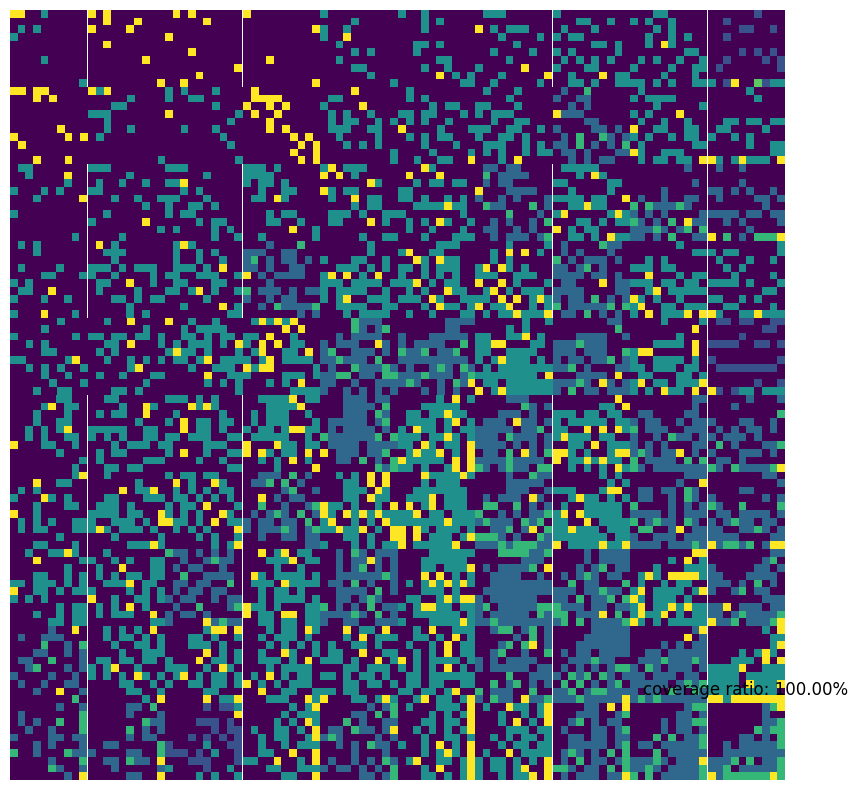

Coverage Ratio: 100.00%


In [51]:
data = load_archive([ind.bd.tolist() for ind in archive.get_content_as_list()])
if env_name == "ant_omni":
    coverageMap2d(data, -15, 15, 100, True)
else:
    coverageMap4d(data, 0, 1, 10, True)

In [39]:
best = selBest(archive.get_content_as_list(), 1, fit_attr="fitness")[0]
print(best.fitness, best.bd)
best = controller.array_to_dict(jnp.array(best))

(485.9486389160156,) [0.05333333 0.46666667 0.29333335 0.41      ]


In [40]:
env = create(params["env_name"], episode_length=params["episode_length"])

In [41]:
random_key, subkey = jax.random.split(random_key)
state = jax.jit(env.reset)(subkey)

In [42]:
jit_step = jax.jit(env.step)
jit_inf = jax.jit(controller.predict)

In [43]:
rollout = []
while not state.done:
    rollout.append(state)
    action = jit_inf(best, state.obs)
    state = jit_step(state, action)


In [44]:
HTML(html.render(env.sys, [s.qp for s in rollout]))